# Problem Statement
### Where will a new guest book their first travel experience?

# Dataset Description
In this challenge, we are given a list of users along with their demographics, web session records, and some summary statistics. We are asked to predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'.

### File descriptions

- train_users.csv - the training set of users


- test_users.csv - the test set of users 
`id: user id 
date_account_created: the date of account creation
timestamp_first_active: timestamp of the first activity, note that it can be earlier than date_account_created or  date_first_booking because a user can search before signing up 
date_first_booking: date of first booking 
gender 
age 
signup_method 
signup_flow: the page a user came to signup up from 
language: international language preference 
affiliate_channel: what kind of paid marketing 
affiliate_provider: where the marketing is e.g. google, craigslist, other 
first_affiliate_tracked: whats the first marketing the user interacted with before the signing up 
signup_app 
first_device_type 
first_browser 
country_destination: this is the target variable you are to predict `


- sessions.csv - web sessions log for users 
`user_id: to be joined with the column 'id' in users table 
action 
action_type 
action_detail 
device_type 
secs_elapsed `


- countries.csv - summary statistics of destination countries in this dataset and their locations 


- age_gender_bkts.csv - summary statistics of users' age group, gender, country of destination 


# Evalutaion Criterion
![Evaluation Criterion](evaluation.png)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.neighbors import KNeighborsClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Draw inline
%matplotlib inline

# Disable warnings from printing
from warnings import filterwarnings
filterwarnings('ignore')

## User Data Processing

In [82]:
# Read the data
train_users = pd.read_csv('../Data/train_users.csv')
test_users = pd.read_csv('../Data/test_users.csv')

# Drop country for processing
LABEL = 'country_destination'
labels = train_users[LABEL].copy()
train_users.drop(LABEL, inplace=True, axis=1)

# Merge train and test users
users = pd.concat((train_users, test_users), axis=0, ignore_index=True)

# Drop id for processing
ids = users["id"].copy()
users.drop("id", inplace=True, axis=1)

### Null values

Creating a new column which counts the number of null values in each record helps to distinguish '-1' as a special type of value (missing) compared to other values.

In [83]:
# Fill null with -1 for missing values
users.fillna(-1, inplace=True)
# -unknown- is another type of missing value
users = users.replace('-unknown-', -1)

# Count number of nulls
users["NumNulls"] = (users == -1).astype(int).sum(axis=1)

### Date Parsing

- Dates cannot be used as such. They are parsed to extract date of the weekday, week number, month, month and year.
- This is done for date_account_created and timestamp_first_active.
- There is another date feature date_first_booking which is completely null for test users. So we can ignore it completely.
- Also compute the difference between dates date_account_created and timestamp_first_active.

In [84]:
# timestamp_first_active pre-processing to get date
users.timestamp_first_active = users.timestamp_first_active.apply(str)
users.timestamp_first_active = users.timestamp_first_active.str[:8]

# Convert strings to dates
users.date_account_created = pd.to_datetime(users.date_account_created, format="%Y-%m-%d")
users.timestamp_first_active = pd.to_datetime(users.timestamp_first_active, format="%Y%m%d")

# Difference in days
users["dac_tfa_diff"] = users["date_account_created"] - users["timestamp_first_active"]
users.dac_tfa_diff = users.dac_tfa_diff.dt.days

def _parse_date(time_dt):
    return [time_dt.year, time_dt.month, time_dt.day, time_dt.weekday(), time_dt.isocalendar()[1]]

def extract_dates_inplace(features, date_column):
    extracted_vals = np.vstack(features[date_column].apply(
        (lambda x: _parse_date(x))))
    for i, period in enumerate(['year', 'month', 'day', 'weekday', 'weekno']):
        features['%s_%s' % (date_column, period)] = extracted_vals[:, i]
    features.drop(date_column, inplace=True, axis=1)

# date_account_created processing
extract_dates_inplace(users, "date_account_created")
extract_dates_inplace(users, "timestamp_first_active")

# Since date_first_booking is null for entire test data, we can simply drop it.
users.drop(['date_first_booking'], inplace=True, axis=1)

### Age
- Age has lot of missing values.
- It also has lot of spurious values like < 14 or > 100.
- Replacing all these with -1.
- We can leave these as -1 or predict all the -1 age values using a classifier such as KNN based on other columns.

In [6]:
# Age is missing for values -1, and spurious values > 100 or < 14
users.age[users.age > 100] = -1
users.age[users.age < 14] = -1

### Categorical Features
- affiliate_channel, affiliate_provider, first_affiliate_tracked, first_browser,                    first_device_type, gender, language, signup_app, signup_method, signup_flow are all the categorical features. They also contain missing values which have been replace by -1.
- Next one hot encoding is carried out on each of them.

In [7]:
CATEGORICAL_FEATURES = ['affiliate_channel', 'affiliate_provider',
                        'first_affiliate_tracked', 'first_browser',
                        'first_device_type', 'gender', 'language', 'signup_app',
                        'signup_method', 'signup_flow']

for feature in CATEGORICAL_FEATURES:
    users = pd.concat((users, pd.get_dummies(users[feature], prefix=feature)), axis=1)
    users = users.drop(feature, axis=1)

In [8]:
# Save processed training and testing data.
training = users[:train_users.shape[0]]
testing = users[train_users.shape[0]:].reset_index().drop("index", axis=1)

# Model
Below is the implementation of a simple XGBoost model that predicts 5 highest likely countries for each user in the test dataset. This is done because of the evaluation metric.

In [9]:
np.random.seed(0)
le = LabelEncoder()
xgb = XGBClassifier(max_depth=6, learning_rate=0.3, n_estimators=25,
                    objective='multi:softprob', subsample=0.5, colsample_bytree=0.5, seed=0)                  
xgb.fit(training, le.fit_transform(labels))
predictions = xgb.predict_proba(testing)

In [10]:
#Taking the 5 classes with highest probabilities
test_ids = ids[train_users.shape[0]:].reset_index().drop("index", axis=1)
ids_result = []  #list of ids
cts_results = []  #list of countries
for i in range(len(test_ids)):
    idx = test_ids.iloc[i]
    ids_result += [idx] * 5
    cts_results += le.inverse_transform(np.argsort(predictions[i])[::-1])[:5].tolist()

#Generate submission
submission = pd.DataFrame(np.column_stack((ids_result, cts_results)), columns=['id', 'country'])
submission.to_csv('../Data/submission.csv',index=False)

# Results
With above minimal feature engineering and XGBoost model we get an NDCG@5 score of 0.86983 and a Kaggle ranking of 715/1500 on the private leaderboard.

# Sessions Data Processing

In [15]:
# Read the sessions data
sessions_data = pd.read_csv("../Data/sessions.csv")

In [16]:
# Get unique user ids to store results
sessions_data_ids = sessions_data.loc[:, ["user_id"]].drop_duplicates().reset_index().drop("index", axis=1)

In [ ]:
# Get number of sessions of each user
sessions_data_ids = sessions_data_ids.join(
    sessions_data.groupby(['user_id'])["user_id"].size().to_frame(),
    on="user_id")
sessions_data_ids.rename(columns={0 : "NumSessions"}, inplace=True)

In [17]:
# Get user ids and actions for action processing
sessions_data_action = sessions_data.loc[:, ["user_id", "action"]]

# Processing for Action attribute
# Replace null values with 'NAN'
sessions_data_action.action = sessions_data_action.action.fillna("NAN")

# Replace infrequent values with 'Other' to avoid overfitting and speed up computation
THRESHOLD = 0.0005*sessions_data_action.shape[0]
counts = sessions_data_action.action.value_counts()
sessions_data_action.action = sessions_data_action.action.apply(lambda x: 'Other' if counts[x] < THRESHOLD else x)

# Get counts of each action for each user
unique_actions = sessions_data_action["action"].unique()

for act in unique_actions:
    sessions_data_ids = sessions_data_ids.join(
        sessions_data_action.loc[sessions_data_action.action == act, :].groupby(['user_id']).size().to_frame(),
        on="user_id")
    sessions_data_ids.rename(columns={0 : "action_" + act}, inplace=True)
    
sessions_data_ids = sessions_data_ids.fillna(0)

# Get mean and std of distribution of counts of actions for each user
sessions_data_ids["NumActionsMean"] = \
sessions_data_ids.loc[:, "action_lookup":"action_similar_listings_v2"].mean(axis=1)

sessions_data_ids["NumActionsStd"] = \
sessions_data_ids.loc[:, "action_lookup":"action_similar_listings_v2"].std(axis=1)

In [ ]:
# Get user ids and action_type for action_type processing
sessions_data_action_type = sessions_data.loc[:, ["user_id", "action_type"]]

# Processing for action_type attribute
# Replace null values with 'NAN'
sessions_data_action_type.action_type = sessions_data_action_type.action_type.fillna("NAN")
sessions_data_action_type.action_type = sessions_data_action_type.action_type.replace(
    {
        '-unknown-': 'NAN'
    }
)

# Replace infrequent values with 'Other' to avoid overfitting and speed up computation
THRESHOLD = 0.005*sessions_data_action_type.shape[0]
counts = sessions_data_action_type.action_type.value_counts()
sessions_data_action_type.action_type = \
sessions_data_action_type.action_type.apply(lambda x: 'Other' if counts[x] < THRESHOLD else x)

# Get counts of each action_type for each user
unique_actions = sessions_data_action_type["action_type"].unique()

for act in unique_actions:
    sessions_data_ids = sessions_data_ids.join(
        sessions_data_action_type.loc[sessions_data_action_type.action_type == act, :].groupby(
            ['user_id']).size().to_frame(),
        on="user_id")
    sessions_data_ids.rename(columns={0 : "action_type_" + act}, inplace=True)
    
sessions_data_ids = sessions_data_ids.fillna(0)

# Get mean and std of distribution of counts of action_type for each user
sessions_data_ids["NumActionTypeMean"] = \
sessions_data_ids.loc[:, "action_type_NAN":"action_type_Other"].mean(axis=1)

sessions_data_ids["NumActionTypeStd"] = \
sessions_data_ids.loc[:, "action_type_NAN":"action_type_Other"].std(axis=1)

In [ ]:
# Repeat procedure for action_detail
# Get user ids and action_detail for action_detail processing
sessions_data_action_detail = sessions_data.loc[:, ["user_id", "action_detail"]]

# Processing for action_detail attribute
# Replace null values with 'NAN'
sessions_data_action_detail.action_detail = sessions_data_action_detail.action_detail.fillna("NAN")
sessions_data_action_detail.action_detail = sessions_data_action_detail.action_detail.replace(
    {
        '-unknown-': 'NAN'
    }
)

# Replace infrequent values with 'Other' to avoid overfitting and speed up computation
THRESHOLD = 0.005*sessions_data_action_detail.shape[0]
counts = sessions_data_action_detail.action_detail.value_counts()
sessions_data_action_detail.action_detail = \
sessions_data_action_detail.action_detail.apply(lambda x: 'Other' if counts[x] < THRESHOLD else x)

# Get counts of each action_type for each user
unique_actions = sessions_data_action_detail["action_detail"].unique()

for act in unique_actions:
    sessions_data_ids = sessions_data_ids.join(
        sessions_data_action_detail.loc[sessions_data_action_detail.action_detail == act, :].groupby(
            ['user_id']).size().to_frame(),
        on="user_id")
    sessions_data_ids.rename(columns={0 : "action_detail_" + act}, inplace=True)
    
sessions_data_ids = sessions_data_ids.fillna(0)

# Get mean and std of distribution of counts of action_detail for each user
sessions_data_ids["NumActionDetailMean"] = \
sessions_data_ids.loc[:, "action_detail_NAN":"action_detail_listing_reviews"].mean(axis=1)

sessions_data_ids["NumActionDetailStd"] = \
sessions_data_ids.loc[:, "action_detail_NAN":"action_detail_listing_reviews"].std(axis=1)

In [ ]:
# Repeat the procedure for device_type
# Get user ids and device_type for device_type processing
sessions_data_device_type = sessions_data.loc[:, ["user_id", "device_type"]]

# Processing for device_type attribute
# Replace null values with 'NAN'
sessions_data_device_type.device_type = sessions_data_device_type.device_type.fillna("NAN")
sessions_data_device_type.device_type = sessions_data_device_type.device_type.replace(
    {
        '-unknown-': 'NAN'
    }
)

# Replace infrequent values with 'Other' to avoid overfitting and speed up computation
THRESHOLD = 0.005*sessions_data_device_type.shape[0]
counts = sessions_data_device_type.device_type.value_counts()
sessions_data_device_type.device_type = \
sessions_data_device_type.device_type.apply(lambda x: 'Other' if counts[x] < THRESHOLD else x)

# Get counts of each action_type for each user
unique_actions = sessions_data_device_type["device_type"].unique()

for act in unique_actions:
    sessions_data_ids = sessions_data_ids.join(
        sessions_data_device_type.loc[sessions_data_device_type.device_type == act, :].groupby(
            ['user_id']).size().to_frame(),
        on="user_id")
    sessions_data_ids.rename(columns={0 : "device_type_" + act}, inplace=True)
    
sessions_data_ids = sessions_data_ids.fillna(0)

# Get mean and std of distribution of counts of device_type for each user
sessions_data_ids["NumDeviceTypeMean"] = \
sessions_data_ids.loc[:, "device_type_Windows Desktop":"device_type_Tablet"].mean(axis=1)

sessions_data_ids["NumDeviceTypeStd"] = \
sessions_data_ids.loc[:, "device_type_Windows Desktop":"device_type_Tablet"].std(axis=1)

In [ ]:
# Get user ids and secs_elapsed for secs_elapsed processing
sessions_data_secs_elapsed = sessions_data.loc[:, ["user_id", "secs_elapsed"]]
sessions_data_secs_elapsed.secs_elapsed = sessions_data_secs_elapsed.secs_elapsed.fillna(0)

# Get simple stats on secs_elapsed
tmp = sessions_data_secs_elapsed.groupby('user_id').aggregate(
    [
        np.mean, np.std, np.median, stats.skew
    ]
)

tmp.columns = ["secs_elapsed_mean", "secs_elapsed_std", "secs_elapsed_median", "secs_elapsed_skew"]

sessions_data_ids = sessions_data_ids.join(tmp, on="user_id")

In [12]:
submission = pd.concat(
    (ids[train_users.shape[0]:].reset_index().drop("index", axis=1),
     testing["predictions"]
    ), axis=1
)
submission.columns = ["id", "country"]
submission.to_csv("../Data/submission.csv", index=False)

KeyError: 'predictions'

In [14]:
CATEGORICAL_FEATURES = ['affiliate_channel', 'affiliate_provider',
                        'first_affiliate_tracked', 'first_browser',
                        'first_device_type', 'gender', 'language', 'signup_app',
                        'signup_method', 'signup_flow']

# A parameter to speed-up computation and avoid overfitting.
# Categorical values that appear less than the threshold will be removed.
THRESHOLD = 0.0005*users.shape[0]

for feature in CATEGORICAL_FEATURES:
    counts = users[feature].value_counts()
    users[feature] = users[feature].apply(lambda x: 'Other' if counts[x] < THRESHOLD else x)

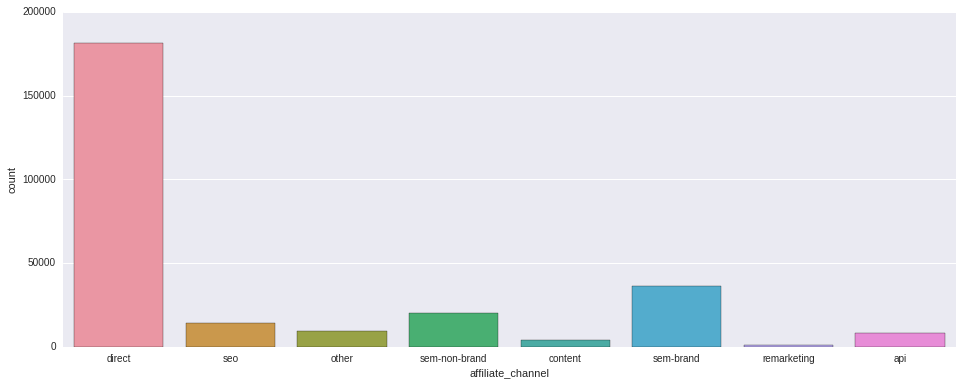

In [15]:
# affiliate_channel processing. No missing values.
plt.rcParams['figure.figsize'] = (16.0, 6.0)
sns.countplot(x='affiliate_channel', data=users)
users.affiliate_channel.describe()

# So can use simple one hot encoding
users = users.join(pd.get_dummies(users['affiliate_channel'], prefix="affiliate_channel"))
  
# Drop the original columns.
users = users.drop(["affiliate_channel"], axis=1)

# Similarly with affiliate_provider
users = users.join(pd.get_dummies(users['affiliate_provider'], prefix="affiliate_provider"))
users = users.drop(["affiliate_provider"], axis=1)

# first_affiliate_tracked processing
# Fill missing values with mode as they are less and mode is extremely common.
# Then apply one-hot encoding as above
users.loc[users.first_affiliate_tracked.isnull(), 'first_affiliate_tracked'] = \
users.loc[:, 'first_affiliate_tracked'].mode()[0]
users = users.join(pd.get_dummies(users['first_affiliate_tracked'], prefix="first_affiliate_tracked"))
users = users.drop(["first_affiliate_tracked"], axis=1)

# Similarly with first_browser
users = users.join(pd.get_dummies(users['first_browser'], prefix="first_browser"))
users = users.drop(["first_browser"], axis=1)

# Similarly with first_device_type
users = users.join(pd.get_dummies(users['first_device_type'], prefix="first_device_type"))
users = users.drop(["first_device_type"], axis=1)

# Similarly with language
users = users.join(pd.get_dummies(users['language'], prefix="language"))
users = users.drop(["language"], axis=1)

# Similarly with signup_app
users = users.join(pd.get_dummies(users['signup_app'], prefix="signup_app"))
users = users.drop(["signup_app"], axis=1)

# Similarly with signup_flow. It is categorical, page number.
users = users.join(pd.get_dummies(users['signup_flow'], prefix="signup_flow"))
users = users.drop(["signup_flow"], axis=1)

# Similarly with signup_method.
users = users.join(pd.get_dummies(users['signup_method'], prefix="signup_method"))
users = users.drop(["signup_method"], axis=1)

In [17]:
# Age is missing for values -1, and spurious values > 95 or < 13
users.age[users.age > 95] = -1
users.age[users.age < 13] = -1

# Now for all missing age values (-1), predict them using KNN
# Augment data with id for original order of records
users["tempIdx"] = users.index

# Get records with age = -1
query_matrix = users[users.age == -1]
    
# Get records with age != -1
search_matrix = users[users.age != -1]

# Predict age using KNN
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(search_matrix.loc[:, "affiliate_channel_api":"date_account_created_weekday"], search_matrix['age'])
query_matrix['age'] = clf.predict(query_matrix.loc[:, "affiliate_channel_api":"date_account_created_weekday"])

# Construct data to original form and order
users = pd.concat((search_matrix, query_matrix), ignore_index=True)
users = users.sort_values(["tempIdx"]).reset_index()
users.drop(["index"], axis=1, inplace=True)
users.drop(["tempIdx"], axis=1, inplace=True)

In [18]:
# Similarly for gender
# Augment data with id for original order of records
users["tempIdx"] = users.index

# Get records with gender="-unknown-"
query_matrix = users[users.gender == "-unknown-"]
    
# Get records with age != -1
search_matrix = users[users.gender != "-unknown-"]

# Predict age using KNN
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(search_matrix.loc[:, "age":"date_account_created_weekday"], search_matrix['gender'])
query_matrix['gender'] = clf.predict(query_matrix.loc[:, "age":"date_account_created_weekday"])

# Construct data to original form and order
users = pd.concat((search_matrix, query_matrix), ignore_index=True)
users = users.sort_values(["tempIdx"]).reset_index()
users.drop(["index"], axis=1, inplace=True)
users.drop(["tempIdx"], axis=1, inplace=True)

# One hot encoding for gender
users = users.join(pd.get_dummies(users['gender'], prefix="gender"))
users = users.drop(["gender"], axis=1)

In [25]:
# Re attach the ids
users = pd.concat((users, ids), axis=1)

In [36]:
# Save processed training and testing data.
training = users[:train_users.shape[0]]
testing = users[train_users.shape[0]:].reset_index().drop("index", axis=1)

### Sessions Data Processing

In [39]:
# Read the sessions data
sessions_data = pd.read_csv("../Data/sessions.csv")

In [40]:
sessions_data[sessions_data.user_id.isnull()]

,user_id,action,action_type,action_detail,device_type,secs_elapsed
6715,NaN,calendar_tab_inner2,-unknown-,-unknown-,Mac Desktop,4890.0
6716,NaN,create,submit,create_user,Mac Desktop,NaN
6717,NaN,header_userpic,data,header_userpic,Mac Desktop,768.0
6718,NaN,calendar_tab_inner2,-unknown-,-unknown-,Mac Desktop,7578.0
19921,NaN,edit,view,edit_profile,iPad Tablet,6194.0
19922,NaN,verify,-unknown-,-unknown-,iPad Tablet,30393.0
19923,NaN,phone_number_widget,-unknown-,-unknown-,iPad Tablet,2304.0
19924,NaN,create,submit,create_phone_numbers,iPad Tablet,66823.0
19925,NaN,update,submit,update_user_profile,iPad Tablet,42489.0
19926,NaN,edit,view,edit_profile,iPad Tablet,64558.0
